In [1]:
from pathlib import Path
import sys

BASE_PATH = Path('../')
PATH_TO_DATA = BASE_PATH/'data'
PATH_TO_MODELS = BASE_PATH/'checkpoints'

PATH_TO_DATA.mkdir(exist_ok=True, parents=True)
PATH_TO_MODELS.mkdir(exist_ok=True, parents=True)

sys.path.append(str(BASE_PATH/'..'))

#### <b>Load Libraries</b>

In [2]:
from tqdm import tqdm
import time
import random
from pathlib import Path
import pickle

from PIL import Image

import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import models
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader, ConcatDataset

from utils import progress_bar, load_model

stty: 'standard input': Inappropriate ioctl for device


#### <b>Notebook Constants</b>

In [3]:
RANDOM_STATE = 42
BATCH_SIZE = 64
NUM_WORKERS = 8
DEVICE = 'cuda'

In [4]:
def set_random_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

#### <b>Define Custom Dataset</b>

In [5]:
class CustomDataset(Dataset):
    def __init__(self, manifest, image_directory, train_mode):

        if train_mode:
            self.transform = transforms.Compose([
                transforms.Resize(128),
                transforms.RandomHorizontalFlip(),
                transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.ToTensor()
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(128),
                transforms.ToTensor()
            ])

        image_directory = Path(image_directory)
        age_class_to_label = {
            "a": 0, "b": 1, "c": 2, "d": 3, "e": 4, "f": 5, "g": 6, "h": 7
        }
        
        self.filenames = [image_directory/x for x in manifest['image_path']]
        self.labels = [age_class_to_label[x] for x in manifest['age_class']]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img = self.transform(Image.open(self.filenames[idx]))
        label = self.labels[idx]

        return img, label

#### <b>Evalution utils</b>

In [6]:
def downstream_task_performance(model, dataloader):
    model.eval()
    top2_correct = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)

            _, preds = outputs.max(1)
            total += targets.size(0)
            correct += preds.eq(targets).sum().item()

            # Top-2 accuracy.
            _, top2_preds = outputs.topk(2, dim=1)
            top2_correct += top2_preds.eq(targets.view(-1, 1).expand_as(top2_preds)).any(dim=1).sum().item()

            progress_bar(batch_idx, len(dataloader), f'Acc: {100*correct/total:.2f}%%% Top2 Acc: {100*top2_correct/total:.2f}%%%')
    
    return 100*correct/total, 100*top2_correct/total

In [7]:
from MIA.score import get_logits, lira_offline, lira_online

def lira(target_net, forget_manifest_filename, retain_manifest_filename, data_split_filename=None):

    num_aug = 1
    fix_variance = False

    train_mode = True if num_aug > 1 else False
    forget_manifest = pd.read_csv(PATH_TO_DATA/forget_manifest_filename)
    retain_manifest = pd.read_csv(PATH_TO_DATA/retain_manifest_filename)
    forget_dataset = CustomDataset(forget_manifest, PATH_TO_DATA/'images', train_mode=train_mode)
    retain_dataset = CustomDataset(retain_manifest, PATH_TO_DATA/'images', train_mode=train_mode)
    dataset = ConcatDataset([forget_dataset, retain_dataset])
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

    if data_split_filename is not None:
        with open(PATH_TO_DATA/data_split_filename, 'rb') as file:
            data_split = pickle.load(file)
    else:
        data_split = None
    
    shadow_nets = [load_model(state_dict).to(DEVICE) for state_dict in (PATH_TO_MODELS/'shadow').glob('*/*')]

    shadow_logits = []
    target_logits = []
    dataset_labels = []

    for _ in range(num_aug):
        shadow_aug_logits = [[] for _ in range(len(shadow_nets))]
        target_aug_logits = []
        with torch.no_grad():
            for batch_idx, (inputs, targets) in tqdm(enumerate(dataloader), total=len(dataloader)):
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                # 1. Store shadow logits
                for i, net in enumerate(shadow_nets):
                    logits = net(inputs).cpu().tolist()
                    shadow_aug_logits[i].append(logits)
                # 2. Store target logits
                logits = target_net(inputs).cpu().tolist()
                target_aug_logits.append(logits)
            
                dataset_labels.append(targets.cpu().tolist())
        

        shadow_aug_logits = np.stack([np.concatenate(logits) for logits in shadow_aug_logits])  # [n_shadow, n_examples, n_classes]
        target_aug_logits = np.concatenate(target_aug_logits)  # [n_examples, n_classes]
        dataset_labels = np.concatenate(dataset_labels)[:, None]  # [n_examples, 1]

        # Extract numerically stable logits
        shadow_aug_logits = get_logits(shadow_aug_logits, np.repeat(dataset_labels[None], len(shadow_nets), 0))
        target_aug_logits = get_logits(target_aug_logits, dataset_labels)

        shadow_logits.append(shadow_aug_logits)
        target_logits.append(target_aug_logits)

    shadow_logits = np.stack(shadow_logits, axis=-1)
    shadow_logits = np.swapaxes(shadow_logits, 0, 1)  # [n_examples, n_shadow, n_aug]
    target_logits = np.stack(target_logits, axis=-1)  # [n_examples, n_aug]
    labels = np.array([0] * len(forget_dataset) + [1] * len(retain_dataset)) # [n_examples]

    if data_split is None:
        fnr, tnr, auc, low = lira_offline(target_logits, shadow_logits, labels, fix_variance=fix_variance)
    else:
        in_datasets = [data_split[x.name] for x in forget_dataset.filenames + retain_dataset.filenames]
        fnr, tnr, auc, low = lira_online(target_logits, shadow_logits, labels, in_datasets, fix_variance=fix_variance)

    return fnr, tnr, auc, low

In [8]:
def evaluate_unlearning(model):

    train_manifest = pd.read_csv(PATH_TO_DATA/'train_manifest.csv')
    train_dataset = CustomDataset(train_manifest, PATH_TO_DATA/'images', train_mode=False)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

    test_manifest = pd.read_csv(PATH_TO_DATA/'test_manifest.csv')
    test_dataset = CustomDataset(test_manifest, PATH_TO_DATA/'images', train_mode=False)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

    train_acc = downstream_task_performance(model, train_dataloader)
    test_acc = downstream_task_performance(model, test_dataloader)
    mia = lira(model, 'forget_manifest.csv', 'retain_manifest.csv', 'data_split_dict.pickle')

    return train_acc, test_acc, mia

#### <b>Evaluate origin model</b>

 [=======================================>]  Step: 32ms | Tot: 772ms | Acc: 87.37%%% Top2 Acc: 96.91% 81/81 
 [======================================>.]  Step: 36ms | Tot: 197ms | Acc: 62.35%%% Top2 Acc: 82.41% 21/21 


100%|██████████| 81/81 [00:39<00:00,  2.04it/s]


train acc: 87.37 top2 train acc: 96.91
test acc: 62.35 top2 test acc: 82.41
mia: 0.007407407407407418


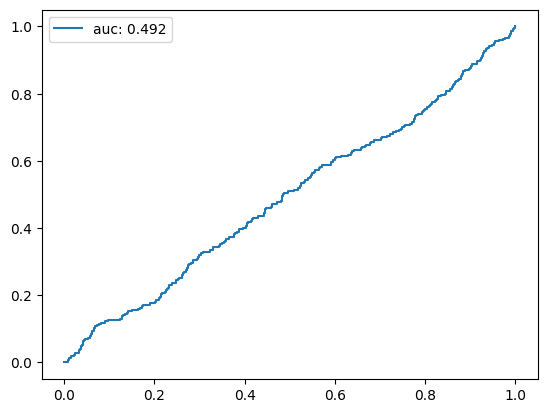

In [9]:
model = load_model(PATH_TO_MODELS/'origin'/'state_dict.pth')
model.to(DEVICE)

train_acc, test_acc, mia = evaluate_unlearning(model)

print(f'train acc: {train_acc[0]:.2f}', f'top2 train acc: {train_acc[1]:.2f}')
print(f'test acc: {test_acc[0]:.2f}', f'top2 test acc: {test_acc[1]:.2f}')
print(f'mia: {mia[-1]}')

plt.plot(mia[0], mia[1], label=f'auc: {metrics.auc(mia[0], mia[1]):.3f}')
plt.legend()

#### <b>Evaluate retrained model</b>

 [=======================================>]  Step: 10ms | Tot: 902ms | Acc: 84.42%%% Top2 Acc: 95.30% 81/81 
 [======================================>.]  Step: 10ms | Tot: 230ms | Acc: 61.34%%% Top2 Acc: 82.48% 21/21 


100%|██████████| 81/81 [00:39<00:00,  2.05it/s]


train acc: 84.42 top2 train acc: 95.30
test acc: 61.34 top2 test acc: 82.48
mia: 0.23703703703703705


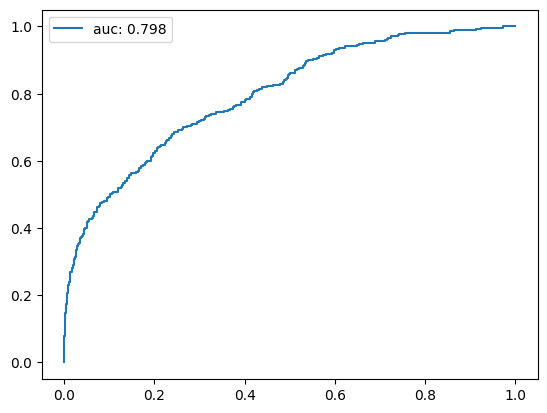

In [10]:
model = load_model(PATH_TO_MODELS/'retrained'/'state_dict.pth')
model.to(DEVICE)

train_acc, test_acc, mia = evaluate_unlearning(model)

print(f'train acc: {train_acc[0]:.2f}', f'top2 train acc: {train_acc[1]:.2f}')
print(f'test acc: {test_acc[0]:.2f}', f'top2 test acc: {test_acc[1]:.2f}')
print(f'mia: {mia[-1]}')

plt.plot(mia[0], mia[1], label=f'auc: {metrics.auc(mia[0], mia[1]):.3f}')
plt.legend()

#### <b>Unlearning</b>

In [13]:
forget_manifest = pd.read_csv(PATH_TO_DATA/'forget_manifest.csv')
retain_manifest = pd.read_csv(PATH_TO_DATA/'retain_manifest.csv')
unseen_manifest = pd.read_csv(PATH_TO_DATA/'unseen_manifest.csv')

##### <b>Fine Tuning</b>

In [15]:
def fine_tune_unlearning(model, forget_manifest, retain_manifest, unseen_manifest):
    
    model.train()
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001)

    dataset = CustomDataset(retain_manifest, PATH_TO_DATA/'images', train_mode=True)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

    num_epochs = 2
    for epoch in range(num_epochs):
        for inputs, targets in tqdm(dataloader, desc=f'epoch {epoch}/{num_epochs}', leave=False):
            
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()

In [17]:
model = load_model(PATH_TO_MODELS/'origin'/'state_dict.pth')
model.to(DEVICE)

fine_tune_unlearning(model, forget_manifest, retain_manifest, unseen_manifest)

train_acc, test_acc, mia = evaluate_unlearning(model)

print(f'train acc: {train_acc[0]:.2f}', f'top2 train acc: {train_acc[1]:.2f}')
print(f'test acc: {test_acc[0]:.2f}', f'top2 test acc: {test_acc[1]:.2f}')
print(f'mia: {mia[-1]}')